# Formative 4

In [1]:
import pickle
from collections import defaultdict, Counter
from string import punctuation

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from nltk.util import bigrams
#from sklearn.feature_extraction import stop_words
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

In [19]:
with open('stopwords.txt', 'r') as f:
    stop_words = f.read().splitlines()

In [2]:
tok = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
with open('bert_vocab.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(list(tok.vocab)))

In [4]:
# Define function to clean text
def clean(text):
    return [w.strip(punctuation) for w in text.strip().split() if w.strip(punctuation) != '']

In [5]:
# Load data
data = pd.read_csv('formative4_data/arxiv_data.csv', encoding='utf-8')

In [6]:
data.head()

,abstract,label
0,the destruction of planets by migration into t...,ap-2010
1,the issue of giant planet formation by core in...,ap-2010
2,deep keck/nirc2 hk'l' observations of the arch...,ap-2010
3,molecular feh provides a large number of sharp...,ap-2010
4,cosmological simulations of galaxy formation o...,ap-2010


In [7]:
# Load fastText embeddings
with open('formative4_data/fasttext_vectors.p', 'rb') as f:
    fasttext_vecs = pickle.load(f)

In [8]:
# Clean abstracts
data['cleaned'] = data.abstract.apply(clean)

In [10]:
# Define list of labels
labels = ['ap-2010', 'ap-2020', 'cs-2010', 'cs-2020']

# Define dictionary for label look-up
label2id = {'ap-2010': 0, 'ap-2020': 1, 'cs-2010': 2, 'cs-2020': 3}

# Define dictionary for reverse label look-up
id2label = {v: k for k, v in label2id.items()}

# Convert labels
data['label'] = data.label.apply(lambda x: label2id[x])

In [12]:
# Split data into training, development, and test sets
train, dev_test = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['label'], random_state=0)

In [13]:
train.label.value_counts()

0    2400
1    2400
2    2400
3    2400
Name: label, dtype: int64

In [13]:
train.head()

,abstract,label,cleaned
7607,this paper discusses highly general mechanisms...,2,"[this, paper, discusses, highly, general, mech..."
1652,in an effort to simultaneously study the gas a...,0,"[in, an, effort, to, simultaneously, study, th..."
11273,"in this paper, we propose a lightweight yet ef...",3,"[in, this, paper, we, propose, a, lightweight,..."
983,we performed stellar population synthesis on t...,0,"[we, performed, stellar, population, synthesis..."
11436,this paper addresses the problem of text-to-vi...,3,"[this, paper, addresses, the, problem, of, tex..."


### Part I: Describing the Dataset

**A) Create counters containing word frequencies for the four classes. Compare the 30 most frequent words for each class. What do you observe?**

In [21]:
# Initialize data structures
vocab_uni = defaultdict(Counter)

# Create vocabularies
for a, l in zip(train.cleaned, train.label):
    vocab_uni[id2label[l]].update([w for w in a if w not in stop_words])

# Inspect most frequent unigrams
for l in labels:
    print('30 most frequent unigrams in {} abstracts:'.format(l), vocab_uni[l].most_common(30))

30 most frequent unigrams in ap-2010 abstracts: [('galaxies', 1699), ('mass', 1592), ('stars', 1512), ('emission', 1330), ('data', 1246), ('star', 1212), ('observations', 1132), ('observed', 1060), ('galaxy', 1037), ('model', 996), ('results', 968), ('using', 962), ('present', 919), ('stellar', 915), ('field', 878), ('x-ray', 875), ('formation', 854), ('models', 847), ('gas', 839), ('magnetic', 769), ('high', 761), ('energy', 760), ('large', 678), ('cluster', 658), ('density', 656), ('sample', 636), ('sources', 633), ('distribution', 632), ('disk', 624), ('evolution', 621)]
30 most frequent unigrams in ap-2020 abstracts: [('galaxies', 1930), ('mass', 1579), ('data', 1406), ('galaxy', 1262), ('using', 1245), ('emission', 1229), ('stars', 1204), ('model', 1199), ('observations', 1147), ('stellar', 1136), ('star', 1114), ('gas', 1073), ('results', 974), ('formation', 971), ('observed', 969), ('x-ray', 905), ('field', 890), ('present', 852), ('models', 840), ('magnetic', 827), ('density', 

The most frequent words in ap-2010 and ap-2020 are very similar and can be roughly split into subject-specific words (_galaxies_, _mass_, _stars_, etc.) and scientific jargon (_observed_, _models_, _results_, etc.). The same holds for the most frequent words in cs-2010 and cs-2020, with some words being subject-specific (_algorithm_, _performance_, _network_, etc.) and some being terms typical for scientific writing (_problem_, _using_, _proposed_, etc.). In general, the lexical differences are much larger between subjects than between years. The temporal differences, on the other hand, seem to be larger for cs than for ap.

**B) Compute the pairwise Jaccard similarities for the vocabularies of all four classes and display them
in a four-by-four similarity matrix. What do you observe? Are the similarities in line with your expectations? Compare the numbers to the Jaccard similarities computed for male and female content words 
in formative 2. What do you observe?**

In [11]:
# Define function for calculating Jaccard similarity
def jaccard_sim(vocab_1, vocab_2):
    return len(vocab_1.intersection(vocab_2)) / len(vocab_1.union(vocab_2))

In [12]:
# Initialize similarity matrix
sims_uni = defaultdict(Counter)

# Fill similarity matrix
for l_1 in labels:
    for l_2 in labels:
        sims_uni[l_1][l_2] = jaccard_sim(set(vocab_uni[l_1]), set(vocab_uni[l_2]))
        
# Display similarity matrix
pd.DataFrame.from_dict(sims_uni, orient='index', columns=labels).reindex(index=labels)

,ap-2010,ap-2020,cs-2010,cs-2020
ap-2010,1.000000,0.274850,0.165022,0.158722
ap-2020,0.274850,1.000000,0.164824,0.163603
cs-2010,0.165022,0.164824,1.000000,0.286798
cs-2020,0.158722,0.163603,0.286798,1.000000


The Jaccard similarity values are overall rather low. They are, e.g., much lower than the values obtained for different genders in formative 2. This suggests that the lexical differences should allow for some success in predicting the subject and year of abstracts from the abstract text. In addition, the similarity values are roughly 0.1 higher when comparing abstracts from the same subject as opposed to the same year, which is in line with the observation made in B). It is also interesting to notice that the temporal differences are slightly larger for cs than ap (0.29 versus 0.27).

**C) Repeat steps A) and B) for bigrams instead of unigrams, i.e., create bigram vocabularies for the four classes, compare the 30 most frequent bigrams, and examine the pairwise Jaccard similarities. Are the observed patterns similar to what you found for unigrams?**

In [13]:
# Initialize data structures
vocab_bi = defaultdict(Counter)

# Create vocabularies
for a, l in zip(train.cleaned, train.label):
    vocab_bi[id2label[l]].update(bigrams([w for w in a if w not in stop_words.ENGLISH_STOP_WORDS]))
    
# Inspect most frequent bigrams
for l in labels:
    print('30 most frequent bigrams in {} abstracts:'.format(l), vocab_bi[l].most_common(30))

30 most frequent bigrams in ap-2010 abstracts: [(('star', 'formation'), 461), (('magnetic', 'field'), 324), (('black', 'hole'), 225), (('et', 'al'), 183), (('dark', 'matter'), 175), (('magnetic', 'fields'), 155), (('stellar', 'mass'), 141), (('dark', 'energy'), 134), (('light', 'curves'), 128), (('emission', 'lines'), 111), (('black', 'holes'), 107), (('space', 'telescope'), 106), (('power', 'spectrum'), 105), (('present', 'results'), 103), (('galaxy', 'clusters'), 102), (('white', 'dwarf'), 94), (('spectral', 'energy'), 90), (('massive', 'stars'), 88), (('light', 'curve'), 87), (('mass', 'function'), 86), (('neutron', 'star'), 85), (('milky', 'way'), 82), (('radial', 'velocity'), 81), (('formation', 'rate'), 78), (('column', 'density'), 75), (('power', 'law'), 74), (('sne', 'ia'), 73), (('globular', 'clusters'), 73), (('angular', 'momentum'), 73), (('high', 'redshift'), 72)]
30 most frequent bigrams in ap-2020 abstracts: [(('star', 'formation'), 461), (('magnetic', 'field'), 396), (('

In [14]:
# Initialize similarity matrix
sims_bi = defaultdict(Counter)

# Fill similarity matrix
for l_1 in labels:
    for l_2 in labels:
        sims_bi[l_1][l_2] = jaccard_sim(set(vocab_bi[l_1]), set(vocab_bi[l_2]))
        
# Display similarity matrix
pd.DataFrame.from_dict(sims_bi, orient='index', columns=labels).reindex(index=labels)

,ap-2010,ap-2020,cs-2010,cs-2020
ap-2010,1.000000,0.079268,0.016787,0.016676
ap-2020,0.079268,1.000000,0.017654,0.019268
cs-2010,0.016787,0.017654,1.000000,0.049667
cs-2020,0.016676,0.019268,0.049667,1.000000


The results for bigrams are overall similar to the results observed for unigrams. The most frequent bigrams can again be split into subject-specific phrases (_magnetic field_, _neural network_, etc.) and scientific jargon (_et al_, _experimental results_, etc.). The Jaccard similarity values are even lower than for unigrams. Interestingly, the trend that temporal differences are larger for cs than ap is much more pronounced for bigrams than for unigrams. 

**D) Now generate an embedding for each abstract by averaging the embeddings for individual words. As in subtasks A), B), and C) (and keeping in mind the results from formative 1), you should again remove stopwords for this 
analysis. Using t-SNE, reduce all abstract embeddings to two dimensions. Plot the resulting two-dimensional vectors colored by label (i.e., subject and year). What do you observe? Based on the plot, 
how would the confusion matrix for predicting the label from the average embedding probably look like?**

In [15]:
# Define function to compute abstract embedding
def abstract2vec(a, vecs):
    return np.array([vecs[w] for w in a if w not in stop_words.ENGLISH_STOP_WORDS]).mean(axis=0)

In [16]:
# Generate abstract embeddings
data['vec'] = data.cleaned.apply(lambda x: abstract2vec(x, fasttext_vecs))

In [17]:
# Create dataset of vectors for t-SNE
tsne_vectors = np.array(list(data['vec']))

# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

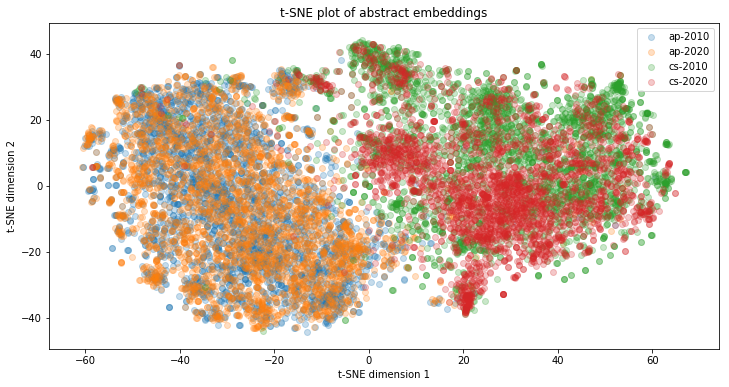

In [18]:
# Plot results
fig, ax = plt.subplots(1, figsize=(12, 6))

for l in labels:
    ax.scatter(tsne_results[data.label==label2id[l], 0], tsne_results[data.label==label2id[l], 1], label=l, alpha=0.25)
ax.set_title('t-SNE plot of abstract embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.legend()

plt.show()

The embeddings form two major clusters in embedding space that correspond to the two subjects. The temporal difference is visible in embedding space to a lesser degree, even though the center of the embeddings for cs-2020 seems to have shifted compared to the embeddings for cs-2010. Overall, this suggest that predicting subject differences might be easier than temporal differences based on neural representation. However, it is important to notice that the models used in this formative do not simply average word embeddings, so the observations should be seen as a lower bound.

### Part II: LSTM Classifier

In [26]:
# Define dataset class
class LSTMDataset(Dataset):

    def __init__(self, data, w2id):
        
        # Encode abstracts
        self.abstracts = list(data.cleaned.apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))
        
        # Store labels
        self.labels = list(data.label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        abstract = self.abstracts[idx]
        label = self.labels[idx]
        return abstract, label

In [27]:
# Define collate function
def lstm_collate(batch):
    
    # Store batch size
    batch_size = len(batch)

    # Separate abstracts and labels
    abstracts = [a for a, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()

    # Store length of longest abstract in batch
    max_len = max(len(a) for a in abstracts)

    # Create padded abstract tensors
    abstracts_pad = torch.zeros((batch_size, max_len)).long()
    for i, a in enumerate(abstracts):
        abstracts_pad[i, :len(a)] = torch.tensor(a)

    return abstracts_pad, labels

In [28]:
# Define LSTM classifier
class LSTMClassifier(nn.Module):
    
    def __init__(self, pretrained_emb, hidden_dim, output_dim):
        
        # Define network layers
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=0)
        self.lstm = nn.LSTM(pretrained_emb.shape[1], hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, abstracts):
            
        # Define flow of tensors through network
        emb = self.embedding(abstracts)
        output, (hidden, cell) = self.lstm(self.dropout(emb))
        return self.linear(self.dropout(output[:, -1, :]))

In [33]:
# Create dictionary for word look-up
word_counter = Counter([w for a in train.cleaned for w in a])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [35]:
# Create datasets
train_dataset = LSTMDataset(train, w2id)
dev_dataset = LSTMDataset(dev, w2id)
test_dataset = LSTMDataset(test, w2id)

In [36]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=lstm_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=lstm_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=lstm_collate)

In [37]:
# Create matrix of pretrained embeddings
fasttext_emb = torch.tensor([fasttext_vecs[id2w[i]] for i in range(2, len(id2w) + 2)]).float()
fasttext_emb = torch.cat((torch.zeros((1, 300)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)

In [26]:
# Initialize model
model = LSTMClassifier(fasttext_emb, 200, 4)

In [27]:
# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [28]:
# Define device and move model to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [29]:
# Train model
for e in range(1, 16):

    model.train()

    for i, b in enumerate(train_loader):
        
        # Perform forward pass
        optimizer.zero_grad()
        abstracts, lbls = [t.to(device) for t in b]
        output = model(abstracts)
        loss = criterion(output, lbls)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()

    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            abstracts, lbls = [t.to(device) for t in b]
            output = model(abstracts)
            max_output = output.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred.extend(max_output.tolist())
            
    print('Development accuracy after {} epoch(s): {:.2f}'.format(e, accuracy_score(y_true, y_pred)))

Development accuracy after 1 epoch(s): 0.25
Development accuracy after 2 epoch(s): 0.25
Development accuracy after 3 epoch(s): 0.33
Development accuracy after 4 epoch(s): 0.50
Development accuracy after 5 epoch(s): 0.51
Development accuracy after 6 epoch(s): 0.50
Development accuracy after 7 epoch(s): 0.52
Development accuracy after 8 epoch(s): 0.55
Development accuracy after 9 epoch(s): 0.59
Development accuracy after 10 epoch(s): 0.58
Development accuracy after 11 epoch(s): 0.63
Development accuracy after 12 epoch(s): 0.62
Development accuracy after 13 epoch(s): 0.38
Development accuracy after 14 epoch(s): 0.57
Development accuracy after 15 epoch(s): 0.62


In [30]:
# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        abstracts, lbls = [t.to(device) for t in b]
        output = model(abstracts)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))

Test accuracy: 0.64


**A) What test accuracy does the LSTM classifier achieve? How does this compare to the performance of a random baseline?**

The LSTM achieves a test accuracy of 0.64. This is way above the random baseline of 0.25. Notice that due to the small dataset size, results for the LSTM can vary drastically for different training runs.

**B) Create a confusion matrix of the true versus predicted labels on the test set. What do you observe? How do the results relate to the expactations developed in Part I?**

In [31]:
# Initialize confusion matrix
c_matrix = defaultdict(Counter)

# Fill confusion matrix
for t, p in zip(y_true, y_pred):
    c_matrix[id2label[t]][id2label[p]] += 1

# Display confusion matrix
pd.DataFrame.from_dict(c_matrix, orient='index', columns=labels).reindex(index=labels)

,ap-2010,ap-2020,cs-2010,cs-2020
ap-2010,22.0,278.0,NaN,NaN
ap-2020,9.0,287.0,3.0,1.0
cs-2010,1.0,1.0,276.0,22.0
cs-2020,NaN,NaN,120.0,180.0


It is strinking to see that there are very little misclassifications along the subject axis. Out of all 600 cs abstracts, e.g., only 2 are classified as ap abstracts. Also, misclassifications along the time axis are more common for ap than cs abstracts, which is in line with our predictions made in Part I (see, e.g., the t-SNE plot). For ap, the model has a pronounced tendency to overpredict ap-2020, i.e., it seems to have failed to learn a distinction between ap-2010 and ap-2020 altogether.

### Part III: BERT Classifier

In [32]:
# Define dataset class
class BERTDataset(Dataset):

    def __init__(self, data):
        
        # Initialize tokenizer
        self.tok = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # Truncate and encode abstracts
        self.abstracts = list(data.abstract.apply(self.tok.encode, truncation_strategy='longest_first', max_length=100))
        
        # Store labels
        self.labels = list(data.label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        abstract = self.abstracts[idx]
        label = self.labels[idx]
        return abstract, label

In [33]:
# Define collate function
def bert_collate(batch):
    
    # Store batch size
    batch_size = len(batch)
    
    # Separate abstracts and labels
    abstracts = [a for a, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()
    
    # Store length of longest abstract in batch
    max_len = max(len(a) for a in abstracts)
    
    # Create padded abstract, mask, and segment tensors
    abstracts_pad = torch.zeros((batch_size, max_len)).long()
    masks_pad = torch.zeros((batch_size, max_len)).long()
    segs_pad = torch.zeros((batch_size, max_len)).long()
    for i, a in enumerate(abstracts):
        abstracts_pad[i, :len(a)] = torch.tensor(a)
        masks_pad[i, :len(a)] = 1
    
    return abstracts_pad, masks_pad, segs_pad, labels

In [34]:
# Define BERT classifier
class BERTClassifier(nn.Module):

    def __init__(self):
        
        # Define network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 4)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, abstracts, masks, segs):
        
        # Define flow of tensors through network
        output_bert = self.bert(abstracts, attention_mask=masks, token_type_ids=segs)[0].mean(axis=1)
        return self.linear(self.dropout(output_bert))

In [35]:
# Create datasets
train_dataset = BERTDataset(train)
dev_dataset = BERTDataset(dev)
test_dataset = BERTDataset(test)

In [36]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=bert_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=bert_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=bert_collate)

In [37]:
# Initialize model
model = BERTClassifier()

In [38]:
# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [39]:
# Define device and move model to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [40]:
# Train model
for e in range(1, 6):

    model.train()

    for i, b in enumerate(train_loader):

        # Perform forward pass
        optimizer.zero_grad()
        abstracts, masks, segs, lbls = [t.to(device) for t in b]
        output = model(abstracts, masks, segs)
        loss = criterion(output, lbls)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()
  
    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            abstracts, masks, segs, lbls = [t.to(device) for t in b]
            output = model(abstracts, masks, segs)
            max_output = output.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred.extend(max_output.tolist())
            
    print('Accuracy after {} epoch(s): {:.2f}'.format(e, accuracy_score(y_true, y_pred)))

Accuracy after 1 epoch(s): 0.71
Accuracy after 2 epoch(s): 0.69
Accuracy after 3 epoch(s): 0.70
Accuracy after 4 epoch(s): 0.68
Accuracy after 5 epoch(s): 0.72


In [41]:
# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        abstracts, masks, segs, lbls = [t.to(device) for t in b]
        output = model(abstracts, masks, segs)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))

Test accuracy: 0.74


**A) What test accuracy does the BERT classifier achieve? How does this compare to the performance of the LSTM classifier?**

BERT achieves a test accuracy of 0.74, which is substantially better than the already well-performing LSTM.

In [42]:
# Initialize confusion matrix
c_matrix = defaultdict(Counter)

# Fill confusion matrix
for t, p in zip(y_true, y_pred):
    c_matrix[id2label[t]][id2label[p]] += 1

# Display confusion matrix
pd.DataFrame.from_dict(c_matrix, orient='index', columns=labels).reindex(index=labels)

,ap-2010,ap-2020,cs-2010,cs-2020
ap-2010,191.0,109.0,NaN,NaN
ap-2020,76.0,222.0,NaN,2.0
cs-2010,1.0,NaN,236.0,63.0
cs-2020,NaN,NaN,64.0,236.0


**B) Create a confusion matrix of the true versus predicted labels on the test set. What do you observe? How do the results relate to the expactations developed in Part I? How do they compare to the confusion matrix for the LSTM classifier?**

There are almost no misclassifications along the subject axis, even less than for the LSTM. Misclassifications along the time axis are again more common for ap than cs abstracts, in accordance with our predictions made in Part I (see, e.g., the t-SNE plot).

**C) Based on the confusion matrix (and taking into account the results from Part II), what conclusions can you draw about the speed with which astrophysics and computer science changed as scientific fields between 2010 and 2020?**

All results in this formative, i.e., the descriptive analyses in Part I, the results of the LSTM in Part II, and the results of BERT in Part III, suggest that the differences between abstracts from 2010 and 2020 are larger for computer science than astrophysics. This indicates that computer science has been changing faster than astrophysics. Looking at the number of abstracts in the full arXiv dataset, we can see that computer science has also experienced a substantial growth between 2010 and 2020. It is hence an interesting question whether the change in computer science is due to a shift or expansion of studied topics. The t-SNE seems to suggest the latter, i.e., the dominant region of cs-2010 abstracts encompasses part of the cs-2020 abstracts, but there is also a region of cs-2020 abstracts without cs-2010 abstracts.

**D) Make predictions about possible advantages and disadvantages of using a model based on n-grams and smoothing (e.g., Naive Bayes) for this task, as opposed to neural models. Your discussion should touch upon the 
unigram and bigram statistics reported in Part I.**

Many scientific concepts have names consisting of more than one word (e.g., _magnetic field_,  _neural network_, etc.). As we have seen in Part I, such bigrams are much more discriminative for subject and year than unigrams, and hence having qualitative representations for them is crucial for the task. In this context, neural models have the advantage that it does not matter whether they have seen a specific bigram in training as long as they have an embedding for both words in the bigram, i.e., the need for smoothing does not occur. This is possible since neural models learn compositional patterns that allow them to combine arbitrary sequences of words into meaningful representations. A Naive Bayes model, on the other hand, would need to completely discard unseen bigrams or use smoothed scores based on, e.g., the unigram scores (in back-off models), which by definition cannot capture compositional effects.